In [5]:
import numpy as np
import networkx as nx

from difflib import SequenceMatcher
from typing import AnyStr
from math import isclose
from itertools import combinations_with_replacement, chain

In [6]:
def adj_product_spaces(
    s1: list[AnyStr | int],
    s2: list[AnyStr | int]
) -> bool:
    """
    Compare whether encoded product spaces are adjacent.
    """
    if s1 == s2:
        return True
    
    len_delta = abs(len(s1) - len(s2))
    total_len = len(s1) + len(s2)
    
    if len_delta > 1:
        return False
     
    matcher = SequenceMatcher()
    matcher.set_seqs(s1, s2)

    # print(f'diff ratio: {1 - matcher.ratio()}')
    # print(f'dist: {(1.0 if len_delta == 1 else 2.0) / total_len}')

    # if equal length, check that approx. Levenshtein distance is 2 
    # if length differs by 1, check that approx. Levenshtein distance is 1
    return isclose(1 - matcher.ratio(), (1.0 if len_delta == 1 else 2.0) / total_len)

In [12]:
def define_space_search_graph(
    spaces: list[AnyStr | int] | set[AnyStr | int],
    maxdim: int,
    connectivity: bool=True
) -> tuple[np.ndarray, list[AnyStr | int]]:
    """
    Computes a graph for adjacent product spaces for spaces and maxdim.
    """
    if maxdim <= 0 or len(spaces) <= 0:
        return np.array([])
    
    spaces = sorted(spaces)

    # evil python trickery!! 
    # unpacking is faster than type conversion or list comprehension
    # choose without replacement sum from i=1 to n_r of (n_s + i - 1 choose i)
    product_spaces = {
        dim: [*combinations_with_replacement(spaces, dim)] for dim in range(1, maxdim + 1)
    }

    indices = list(chain.from_iterable(product_spaces.values()))
    inv_map = {indices[i]: i for i in range(len(indices))}

    nodes = len(indices)
    distances = np.zeros((nodes, nodes), np.float32) # + np.diag(np.ones(nodes) * np.inf)

    for dim, s in product_spaces.items():
        for curnode in s:
            # compare against adjacent dimensions
            if dim > 1:
                for compnode in product_spaces[dim - 1]:
                    if inv_map[compnode] <= inv_map[curnode]:
                        continue

                    if adj_product_spaces(curnode, compnode):
                        distances[inv_map[compnode]][inv_map[curnode]] = 1

            if dim < maxdim:
                for compnode in product_spaces[dim + 1]:
                    if inv_map[compnode] <= inv_map[curnode]:
                        continue

                    if adj_product_spaces(curnode, compnode):
                        distances[inv_map[compnode]][inv_map[curnode]] = 1

            # compare against current dimension
            for compnode in s:
                if inv_map[compnode] <= inv_map[curnode]:
                    continue

                if adj_product_spaces(curnode, compnode):
                    distances[inv_map[compnode]][inv_map[curnode]] = 1
                
    return (distances + distances.T - np.diag(np.diag(distances)), indices)

In [24]:
distances, idxs = define_space_search_graph(['a', 'b', 'c'], 12)

In [25]:
graph = nx.from_numpy_array(distances)

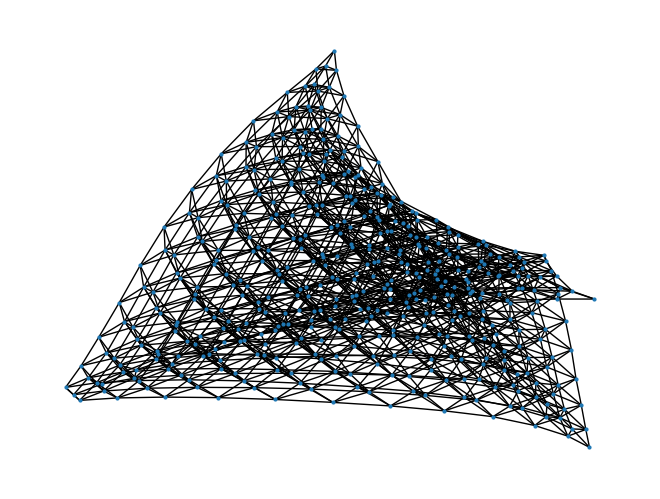

In [32]:
nx.draw(graph, pos=nx.spring_layout(graph), node_size=4)